In [267]:
# Load required Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import pdist, squareform

from pca import pca

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


### use UsArrests.csv to generate a in-depth PCA report of the data
Explore as much as you can, motivate the pre-processing steps you take, and interpret the outcomes of any analysis

In [268]:
# load dataset
df = pd.read_csv('UsArrests.csv')
df.head(2)

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5


In [269]:
# check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


_The dataset have 5 features. It contains statistics of number of arrests made per 100 000 residents for 3 types of crimes (Murder, Assault, Rape) within each 50 states._

_In the report, PCA and hierarchical clustering will be used to represent how each crime attributes itself to each state. Therefore, segragation on the data can be made with City being the response variable, while crime and population are predictor variables._

In [270]:
# check statistical summary of the dataset
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


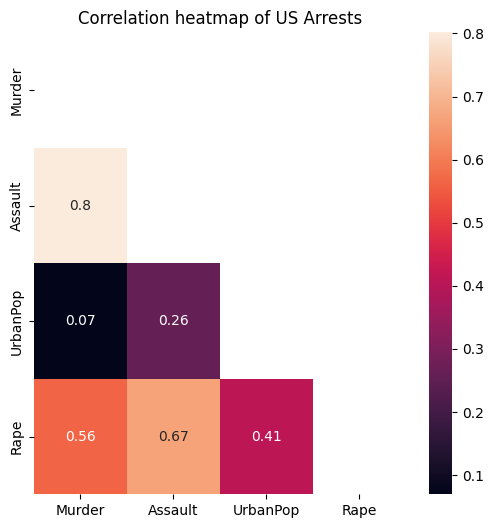

In [271]:
# check correlations of features in the dataset
plt.figure(figsize=(6,6))
ua_corr = df.corr()

# mask mirrored side of heatmap
dropmirror = np.zeros_like(ua_corr)
dropmirror[np.triu_indices_from(dropmirror)] = True

sns.heatmap(ua_corr, annot=True, mask=dropmirror)
plt.title('Correlation heatmap of US Arrests')
plt.show()


_It seems all features present positive correlation at different levels._

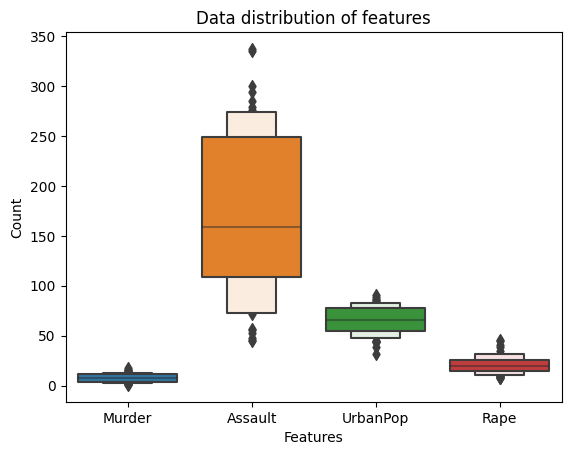

In [272]:
# use a boxplot to check feature distributions
sns.boxenplot(data=df)
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Data distribution of features')
plt.show()

_From the boxplot, it seems that 'Assault' has very high number count and all the features do not in the similar level as well. Therefore, data scalling needs to be carried out._

#### data scalling
to ensure each feature is within the same range of values

In [273]:
# select independent and standardize it
scaled = StandardScaler().fit_transform(df.iloc[:, 1:5])
scaled_df = pd.DataFrame(scaled, columns=df.columns[1:5])
scaled_df.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


#### selecting number of components for PCA

In [274]:
# apply PCA
pca_1 = PCA().fit(scaled_df)
pca_1.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

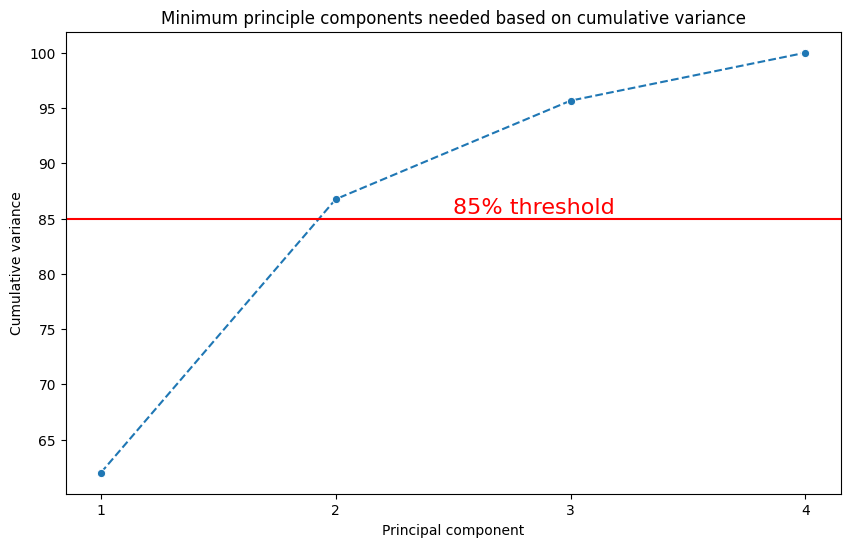

In [275]:
# plot a graph showing components needed for the analysis
X = np.arange(1, 5, step=1)
plt.figure(figsize=(10, 6))
sns.lineplot(x=X, y=np.cumsum(pca_1.explained_variance_ratio_)*100, linestyle='--', marker='o')
plt.title('Minimum principle components needed based on cumulative variance')
plt.xlabel('Principal component')
plt.xticks(np.arange(1, 5, step=1))
plt.ylabel('Cumulative variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color='r', fontsize=16)
plt.show()

_From above graph, Component 1 provides 62% of all variances in the data. Component 1 and 2 provide 86.7% of variances in the data. This means that half of the data can be removed while maintaining  86.7% explanationn value to present how features affect each other._

In [276]:
# select and proceed with 2 components
pca_2 = PCA(n_components=2)
pca_t = pca_2.fit_transform(scaled_df)
pca_t.shape

(50, 2)

In [277]:
# transform the components into a pandas dataframe
pca_tdf = pd.DataFrame(data = pca_t, columns=['PC1', 'PC2'])
pca_tdf['City'] = df['City']
pca_tdf.head()

,PC1,PC2,City
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


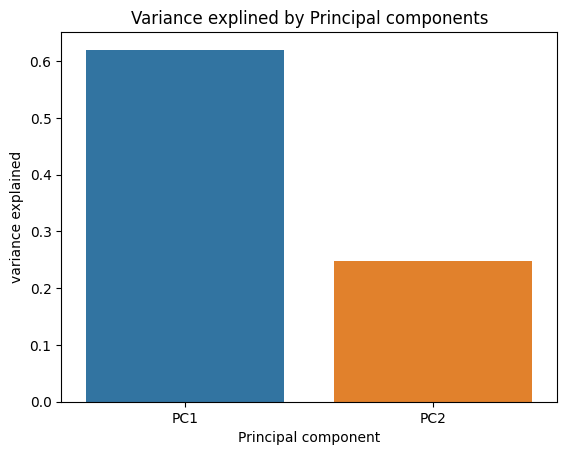

In [278]:
# creat a barplot to visually represent how each Component affects the variance
df = pd.DataFrame({'variance explained': pca_2.explained_variance_ratio_, 'Principal component': ['PC1', 'PC2']})
plt.title('Variance explined by Principal components')
sns.barplot(x='Principal component', y='variance explained', data=df)
plt.show()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


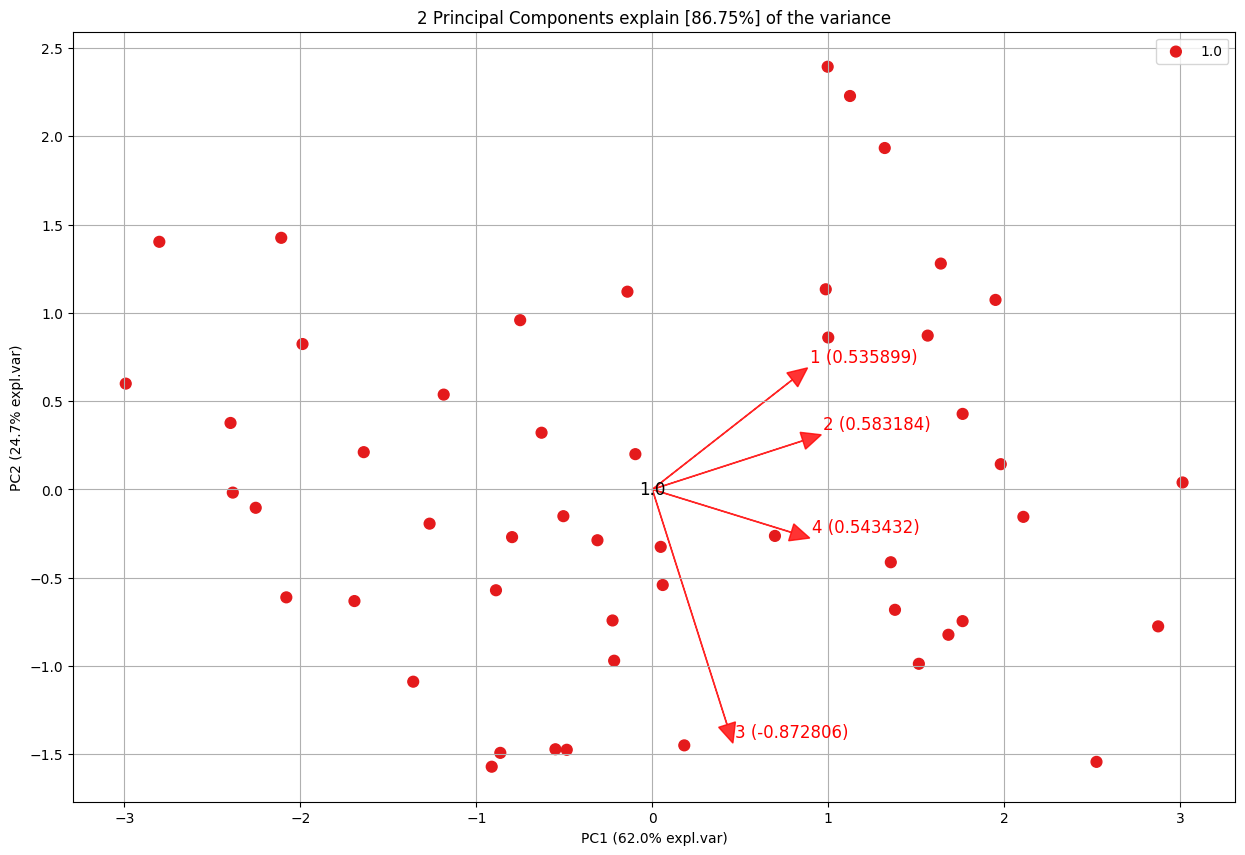

In [279]:
# create a biplot to represent components within the total dataFrame
model = pca(n_components=2)
results = model.fit_transform(scaled)

# make biplot with the total number of features
fix, ax = model.biplot(n_feat=4,)

_pca is a package for Principal Component Analysis, here is used to create Biplot to plot the loadings. loadings range from -1 to 1. A high absolute value (towards 1 or -1) describes that the variable strongly influences the component. Values close to 0 indicate that the variable has a weak influence on the component._

_The above graph shows the observations as points in the plane formed by two Principle components. Samples are displayed as points. The different cities are all points on the biplot. Vectors indicate different variables._


_Each variable shown has a positive correlation with PC1. The feature component - 'UrbanPop' denoted here by '3' has the relatively highest correlation with the PC2. Moreover, it is the only correlation that is negative._

### do an application of two clustering techniques and an analysis of the clusters they generate
try and see if you can find anything common within each cluster that has been found

use PCA selected features (pca_tdf )

In [280]:
# prepare data for training, note that there is no need to supply y for unsupervised task
# use PCA selected features PC1 and PC2
x = pca_tdf[['PC1', 'PC2']].values.reshape(-1, 2)
print('Data size:', x.shape)


Data size: (50, 2)


#### 1) clustering 1 _ KMean

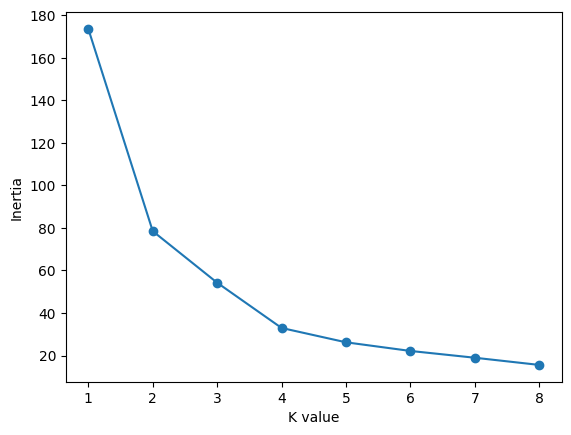

In [281]:
# use KMean
# selecting k
def eval_Kmeans(x, k):
    kmeans = KMeans(n_clusters=k, random_state=20)
    kmeans.fit(x)
    return kmeans.inertia_
def elbow_Kmeans(x, max_k=8):
    within_cluster_vars = [eval_Kmeans(x, k) for k in range(1, max_k+1)]
    plt.plot(range(1,max_k+1), within_cluster_vars, marker='o')
    plt.xlabel('K value')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(x)


_The elbow runs from k=2 to k=4. This can be analysed further use silhouette score._ 

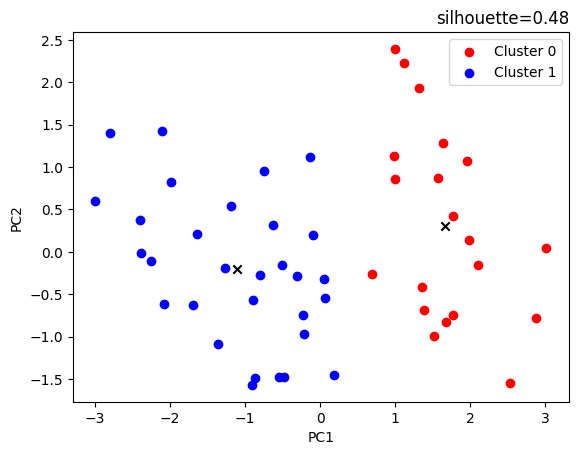

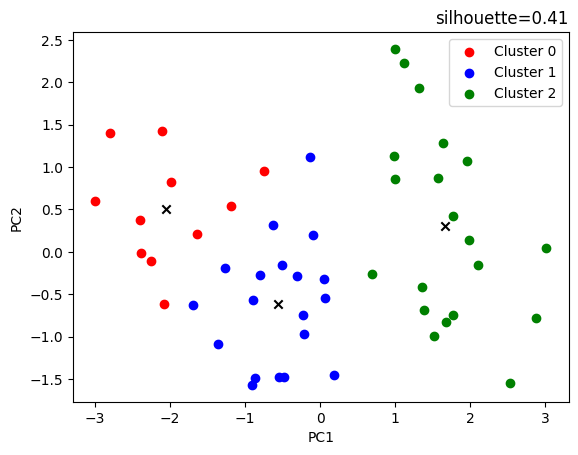

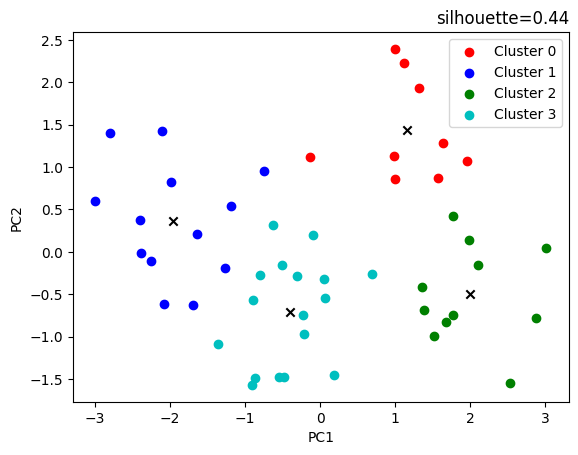

In [282]:
def scatter_Kmeans(x, k):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=20)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
        plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
        plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)
    plt.title(f'silhouette={score}', loc='right')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()

for k in range(2, 5):
    scatter_Kmeans(x,k)
    


_From above results, it seems that the best silhouette score 0.48 is achieved using k=2._

#### 2) clustering 2 _ Hierarchical AgglomerativeClustering

- check which gives better result from Euclidean and Cityblock distance metrics
- print their dendrograms 


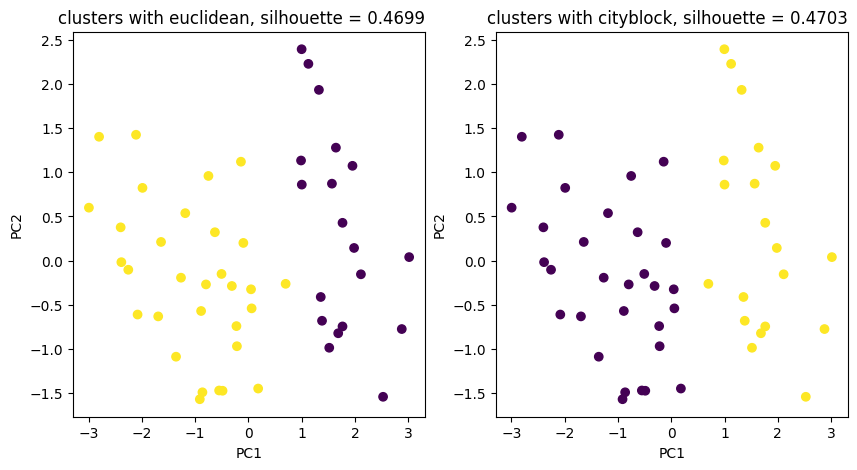

In [283]:
# use AgglomerativeClustering
# plot their dendrograms
plt.figure(figsize=(10,5))
metrics = ['euclidean', 'cityblock']
for i, l in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    cluster1 = AgglomerativeClustering(n_clusters=2, affinity=l, linkage='complete')
    cluster1.fit_predict(x)

    ax = plt.scatter(x[:,0], x[:,1], c=cluster1.labels_)
    silhouette_score1 = silhouette_score(x, cluster1.labels_, metric=l)


    plt.title(f'clusters with {l}, silhouette = {"%.4f" % silhouette_score1}', loc='right')
    plt.xlabel('PC1')
    plt.ylabel('PC2')    

_For Hierarchical AgglomerativeClustering, it seems that affinity using both Euclidean and Cityblock distance metrics provides very similar silhouette score values of about 0.47._




_Silhouette score is a metric used to calculate the goodness of clustering technique. Its value ranges from -1 to 1._
- 1 means clusters are well apart from each other and clearly distinguished
- 0 means clusters are indifferent, or the distance between clusters is not significant
- -1 means clusters are assigned in the wrong way



_From above results, KMeans clustering seem to work better with the dataset. When using n_clusters value of 2, highest silhouette score of 0.48 was obtained. This means that the clusters are apart from each other, but are not well enough._

### push all the work that you have generated for this project to GibHub

https://github.com/zf0206/Bootcamp/blob/7a3c8a40178bd0917b91309acf0f83eb4677998a/T51%20task.ipynb